In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import csv, warnings, math
import anchors
from poola import core as pool
from scipy.stats import ttest_ind
from scipy.interpolate import CubicSpline
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from adjustText import adjust_text

import core_functions as fns

gpp.set_aesthetics(palette='Set2')


In [2]:
#Process data

def reformat_pDNA(df): 
    '''
    Inputs: df: pDNA dataframe from Poirier data set 
    Output: new_df: reformatted pDNA dataframe 
    '''
    #sgRNA: CHDH_GTGCCCACGGACGTAGACCA --> GTGCCCACGGACGTAGACCA
    new_df = df.copy()
    new_df = new_df.rename(columns = {'Guide': 'old_Guide', 'Reads':'pDNA'})
    new_guide_list = []
    gene_count = 1
    control_df = pd.DataFrame(columns = df.columns)
    df_dict = {}
    prev_gene = ''
    for i, row in enumerate(new_df.loc[:,'old_Guide']):
        gene = new_df.loc[i, 'Gene Symbol']
#         if 'Non-Targeting' in gene:
#             new_df.loc[i, 'Gene Symbol'] = 'Non-Targeting_'+str(i)
            #print(control_df)
        new_guide = row.split('_')[1]
        new_guide_list.append(new_guide) 
        #prev_gene = gene
    
    new_df['Guide'] = new_guide_list
    new_df = new_df.drop('old_Guide', axis = 1)
    new_df = new_df[['Guide', 'Gene Symbol', 'pDNA']]

    return new_df


## Data Summary

* Zhu et al.
* Cell line: A549 (overexpressing ACE2)
* Library: Brunello

In [3]:
#Read counts
reads_raw = pd.read_excel('../../Data/Reads/Zhang/A549-ACE2 KO SARS2 screening count.xlsx')
reads_raw = reads_raw.rename(columns = {'sgRNA': 'Guide', 'Gene':'Gene Symbol'})
#pDNA reads from Schneider et al.(Poirier) 
pDNA_reads_raw = pd.read_excel('../../Data/Reads/Poirier/Poirier_Brunello_pDNA.xlsx') # controls already grouped 
pDNA_reads = reformat_pDNA(pDNA_reads_raw)
reads = pd.merge(pDNA_reads, reads_raw, on = 'Guide', how = 'right')
reads = reads.drop('Gene Symbol_y', axis = 1)
reads = reads.rename(columns={'Gene Symbol_x':'Gene Symbol'})
reads

,Guide,Gene Symbol,pDNA,Control,Treatment
0,CATCTTCTTTCACCTGAACG,A1BG,118,1344,129
1,CTCCGGGGAGAACTCCGGCG,A1BG,68,819,200
2,TCTCCATGGTGCATCAGCAC,A1BG,2,3,20
3,TGGAAGTCCACTCCACTCAG,A1BG,116,1062,228
4,ACTGCATCTGTGCAAACGGG,A2M,70,766,146
...,...,...,...,...,...
77436,TTTGGTCAACGCATAGCTTG,Non-Targeting_94,182,2064,93
77437,TTTTACCTTGTTCACATGGA,Non-Targeting_82,177,2119,128
77438,TTTTGACTCTAATCACCGGT,Non-Targeting_225,107,1381,170
77439,TTTTTAATACAAGGTAATCT,Non-Targeting_25,55,1135,61


In [4]:
#Calculate lognorm

cols = reads.columns[2:].to_list() #reads columns are 3rd onward in df
lognorms = fns.get_lognorm(reads.dropna(), cols = cols)
lognorms

,Guide,Gene Symbol,pDNA_lognorm,Control_lognorm,Treatment_lognorm
0,CATCTTCTTTCACCTGAACG,A1BG,4.468511,4.724628,2.432842
1,CTCCGGGGAGAACTCCGGCG,A1BG,3.720468,4.044591,2.967358
2,TCTCCATGGTGCATCAGCAC,A1BG,0.441787,0.079682,0.750266
3,TGGAAGTCCACTCCACTCAG,A1BG,4.444972,4.399295,3.133558
4,ACTGCATCTGTGCAAACGGG,A2M,3.759158,3.954108,2.579988
...,...,...,...,...,...
77436,TTTGGTCAACGCATAGCTTG,Non-Targeting_94,5.070563,5.324376,2.060662
77437,TTTTACCTTGTTCACATGGA,Non-Targeting_82,5.031586,5.361382,2.423701
77438,TTTTGACTCTAATCACCGGT,Non-Targeting_225,4.334018,4.762345,2.765083
77439,TTTTTAATACAAGGTAATCT,Non-Targeting_25,3.440005,4.490800,1.623124


## Quality Control
### Population Distributions

../../Figures/A549_Brunello_Zhang_popdist.png


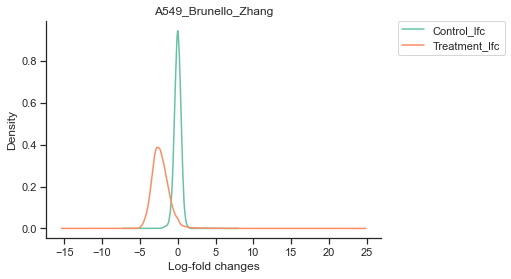

In [5]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, initial_id='Control', res_id='Treatment', filename = 'A549_Brunello_Zhang')

### Control Distributions

../../Figures/A549_Brunello_Zhang_controldist.png


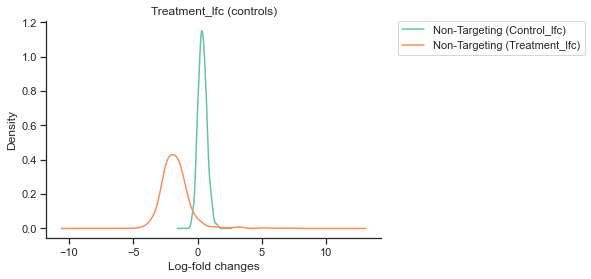

In [6]:
fns.control_dist_plot(pDNA_lfc, initial_id='Control', res_id='Treatment', control_name=['Non-Targeting'], filename = 'A549_Brunello_Zhang')

### ROC-AUC

Text(0, 0.5, 'True Positive Rate (essential)')

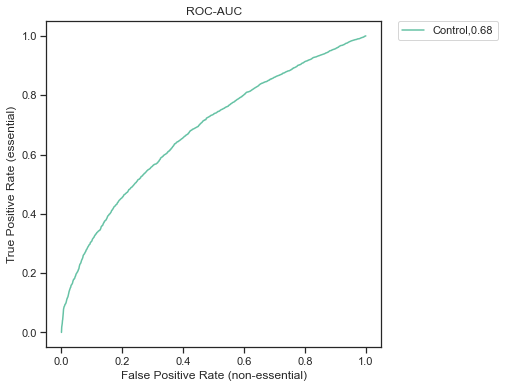

In [7]:
ess_genes, non_ess_genes = fns.get_gene_sets()

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()
tp_genes

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col='Control_lfc')

fig,ax=plt.subplots(figsize=(6,6))
ax=sns.lineplot(data=roc_df, x='fpr',y='tpr', ci=None, label = 'Control,' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene-level analysis

### Residual z-scores

In [8]:
#Calculate z-scores of lfc residuals
lfc_df = pDNA_lfc.copy().drop(['Gene Symbol'], axis = 1)
lfc_df = lfc_df.dropna()

guide_residuals_lfcs, all_model_info, model_fit_plots = fns.run_guide_residuals(lfc_df, initial_id='Control', res_id='Treatment')

guide_mapping = pDNA_lfc[['Guide', 'Gene Symbol']]

gene_residuals = anchors.get_gene_residuals(guide_residuals_lfcs, guide_mapping)
gene_residuals

        modified  unperturbed
0  Treatment_lfc  Control_lfc


,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Treatment_lfc,A1BG,4,-0.947928,0.043115,2.246416,0.024677,0.580965
1,Treatment_lfc,A1CF,4,-2.633417,0.308452,-1.275733,0.202050,0.999409
2,Treatment_lfc,A2M,4,-2.391853,0.364319,-0.945705,0.344299,0.999409
3,Treatment_lfc,A2ML1,4,-1.917494,-0.007532,0.597194,0.550378,0.999409
4,Treatment_lfc,A3GALT2,4,-1.298894,0.038376,1.618824,0.105485,0.948595
...,...,...,...,...,...,...,...,...
19359,Treatment_lfc,ZYG11A,4,-1.934661,0.064359,0.433823,0.664417,0.999409
19360,Treatment_lfc,ZYG11B,4,-2.430009,-0.068091,-0.225112,0.821892,0.999409
19361,Treatment_lfc,ZYX,4,-1.370474,-0.007905,1.583137,0.113390,0.956970
19362,Treatment_lfc,ZZEF1,4,-1.404886,-0.288910,2.009764,0.044456,0.756059


In [9]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 3, guide_max = 5)
guide_residual_sheet = pd.merge(guide_mapping, guide_residuals_lfcs, on = 'Guide', how = 'outer')
guide_residual_sheet

['Treatment_lfc']


,Guide,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,CATCTTCTTTCACCTGAACG,A1BG,Treatment_lfc,-0.059254,-0.053298,Control_lfc,-2.035669,0.256117
1,CTCCGGGGAGAACTCCGGCG,A1BG,Treatment_lfc,1.152371,1.036536,Control_lfc,-0.753110,0.324123
2,TCTCCATGGTGCATCAGCAC,A1BG,Treatment_lfc,2.920745,2.627153,Control_lfc,0.308478,-0.362106
3,TGGAAGTCCACTCCACTCAG,A1BG,Treatment_lfc,0.981056,0.882440,Control_lfc,-1.311413,-0.045676
4,ACTGCATCTGTGCAAACGGG,A2M,Treatment_lfc,0.861268,0.774694,Control_lfc,-1.179169,0.194950
...,...,...,...,...,...,...,...,...
77436,TTTGGTCAACGCATAGCTTG,Non-Targeting_94,Treatment_lfc,-1.031079,-0.927436,Control_lfc,-3.009901,0.253814
77437,TTTTACCTTGTTCACATGGA,Non-Targeting_82,Treatment_lfc,-0.708310,-0.637111,Control_lfc,-2.607885,0.329796
77438,TTTTGACTCTAATCACCGGT,Non-Targeting_225,Treatment_lfc,0.228353,0.205399,Control_lfc,-1.568935,0.428327
77439,TTTTTAATACAAGGTAATCT,Non-Targeting_25,Treatment_lfc,-0.654214,-0.588453,Control_lfc,-1.816881,1.050795


In [10]:
with pd.ExcelWriter('../../Data/Processed/GEO_submission_v2/A549_Brunello_Zhang.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='A549_Brunello_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='A549_Brunello_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='A549_Brunello_guide_mapping', index =False)

In [11]:
with pd.ExcelWriter('../../Data/Processed/Individual_screens_v2/A549_Brunello_Zhang_v2.xlsx') as writer:   
    gene_residuals.to_excel(writer, sheet_name='gene-level_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)